# Problem set 4 - Solutions

# Problem 1

# First read the data

Corresponding files:

- GW150914 - H-H1_LOSC_4_V2-1126259446-32.hdf5 - L-L1_LOSC_4_V2-1126259446-32.hdf5 - GW150914_4_template.hdf5
- GW151226 - H-H1_LOSC_4_V2-1135136334-32.hdf5 - L-L1_LOSC_4_V2-1135136334-32.hdf5 - GW151226_4_template.hdf5
- LVT151012 - H-H1_LOSC_4_V2-1128678884-32.hdf5 - L-L1_LOSC_4_V2-1128678884-32.hdf5 - LVT151012_4_template.hdf5
- GW170104 - H-H1_LOSC_4_V1-1167559920-32.hdf5 - L-L1_LOSC_4_V1-1167559920-32.hdf5 - GW170104_4_template.hdf5


In [19]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
plt.ion()

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print(dataFile.keys())
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)
    dataFile.close()
    return strain,dt,gpsStart,utc


# The directory where I unzipped the data
fdir='/Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/' ### change directory into your own directory
#fdir='.'

fname_H = [fdir+'H-H1_LOSC_4_V2-1126259446-32.hdf5',fdir+'H-H1_LOSC_4_V2-1135136334-32.hdf5',fdir+'H-H1_LOSC_4_V2-1128678884-32.hdf5',
fdir+'H-H1_LOSC_4_V1-1167559920-32.hdf5']

fname_L = [fdir+'L-L1_LOSC_4_V2-1126259446-32.hdf5',fdir+'L-L1_LOSC_4_V2-1135136334-32.hdf5',fdir+'L-L1_LOSC_4_V2-1128678884-32.hdf5',
           fdir+'L-L1_LOSC_4_V1-1167559920-32.hdf5']

templates = [fdir+'GW150914_4_template.hdf5',fdir+'GW151226_4_template.hdf5',fdir+'LVT151012_4_template.hdf5',fdir+'GW170104_4_template.hdf5']

GWs = ['GW150914','GW151226','LVT151012','GW170104']

strain_H, dt_H, time_H, gps_H,utc_H = [],[],[],[],[]

strain_L, dt_L, time_L, gps_L,utc_L = [],[],[],[],[]

t_H, t_L = [],[]

# read all the data at once, and save strain, dt and utc
for i in range(len(fname_H)):
    print('reading Hanford file ',fname_H[i])
    print('reading Livingston file ',fname_L[i])
    print('reading corresponding template ',templates[i])
    # save Hanford data
    strainH,dtH,gpsH,utcH=read_file(fname_H[i])
    timeH = np.linspace(gpsH,gpsH+32,len(strainH))
    strain_H.append(strainH)
    dt_H.append(dtH)
    time_H.append(timeH)
    gps_H.append(gpsH)
    utc_H.append(utcH)
    # save Livingston data
    strainL,dtL,gpsL,utcL=read_file(fname_L[i])
    timeL = np.linspace(gpsL,gpsL+32,len(strainL))
    strain_L.append(strainL)
    dt_L.append(dtL)
    time_L.append(timeL)
    gps_L.append(gpsL)
    utc_L.append(utcL)
    # saving template
    th,tl=read_template(templates[i])
    t_H.append(th)
    t_L.append(tl)


reading Hanford file  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
reading Livingston file  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
reading corresponding template  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/GW150914_4_template.hdf5
reading Hanford file  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
reading Livingston file  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5
reading corresponding template  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event_tutorial/GW151226_4_template.hdf5
reading Hanford file  /Users/constanza/Desktop/McGill/Comp Physics/Problem-Sets/Problem set 4/LOSC_Event

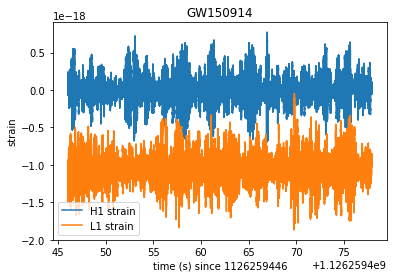

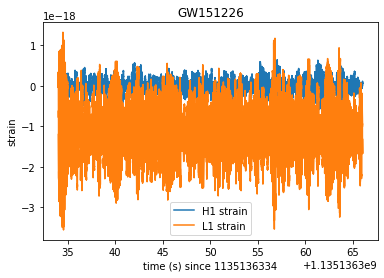

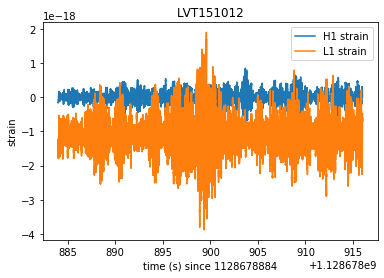

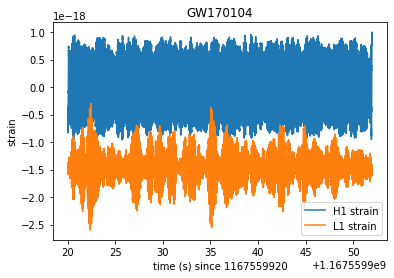

In [20]:
# Plot the H and L data for each GW

for i in range(len(fname_H)):
    plt.figure()
    plt.title(GWs[i])
    plt.plot(time_H[i],strain_H[i],label = 'H1 strain')
    plt.plot(time_L[i],strain_L[i],label = 'L1 strain')
    plt.xlabel('time (s) since '+repr(gps_H[i]))
    plt.ylabel('strain')
    plt.legend(loc='best')
    plt.show()

## Part a)

Coming up with a noise model means:
- Apply a window to the strain data, to avoid spectral leakage (discontinuity of the data) when transforming to fourier space.
- Take the power spectrum, which corresponds to the absolute value of fourier transform of the strain, squared ($|FT(strain)|^2$).
- Smooth the power spectrum.
- Get rid of the noise that is not physical, and comes from fourier transforming (low and high frequencies)
- The result of all this process is the noise model

In [21]:
# step 1: window the data
# step 2: compute power spectrum
# step 3: smooth with gaussian
# step 4: cut low and high frequencies
# up to here data is clean
# step 5: window the template
# dont smooth it!
# step 6: cut low and high frequencies 

First step is to window the data to avoid discontinuity in the signal

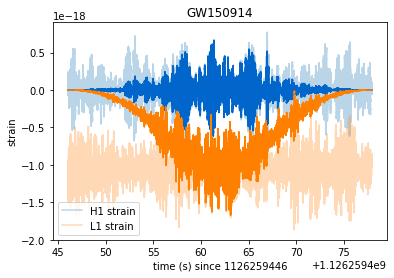

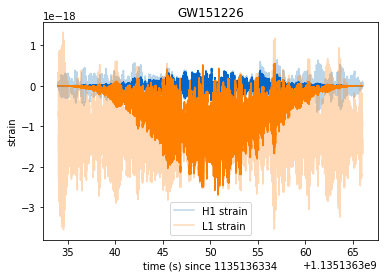

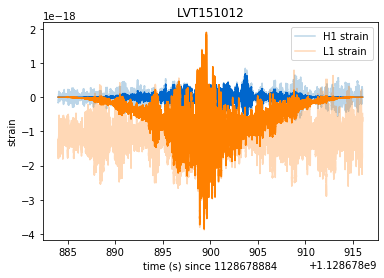

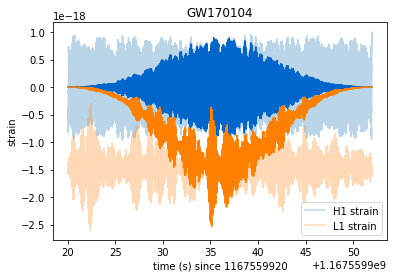

In [22]:
window_strain_H = []
window_strain_L = []

for i in range(len(fname_H)):
    window_H = np.blackman(len(strain_H[i]))
    new_strain_H = strain_H[i]*window_H
    window_strain_H.append(new_strain_H)
    window_L = np.blackman(len(strain_L[i]))
    new_strain_L = strain_L[i]*window_L
    window_strain_L.append(new_strain_L)
    plt.figure()
    plt.title(GWs[i])
    plt.plot(time_H[i],strain_H[i],label = 'H1 strain',alpha=0.3)
    plt.plot(time_L[i],strain_L[i],label = 'L1 strain',alpha=0.3)
    plt.plot(time_H[i],new_strain_H,color='#0066CC')
    plt.plot(time_L[i],new_strain_L,color='#FF8000')
    plt.xlabel('time (s) since '+repr(gps_H[i]))
    plt.ylabel('strain')
    plt.legend(loc='best')
    plt.show()


Then compute the power spectrum.

But what is the power spectrum?
- it tells us how much energy (or power, energy/time) is contained in each frequency bin
How is it generated?
- by using the fast fourier transform, that help us to compute the fourier transform of a data sample
- specifically, it is calculated by taking the square of the absolute value of the fourier transform, i.e., $|FT|^2$

A quick summary can be found here: https://www.wikilectures.eu/w/Frequency_and_power_spectra

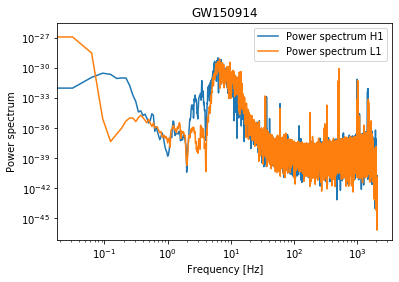

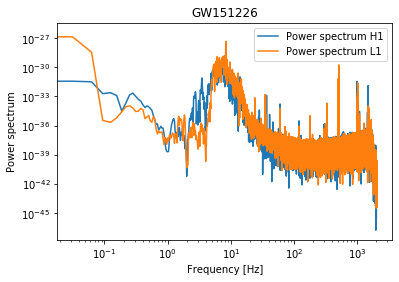

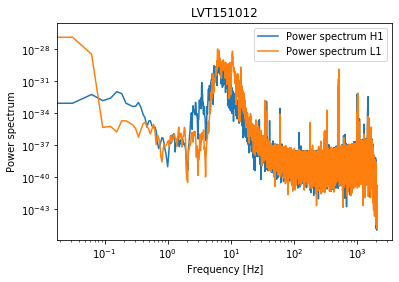

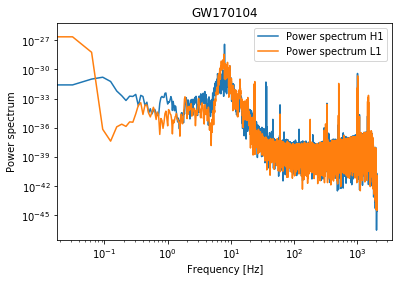

In [23]:
power_spectra_H = []
power_spectra_L = []
frequency_H = []
frequency_L = []

for i in range(len(fname_H)):
    # compute power spectrum for H
    pow_spec_H = np.abs(np.fft.rfft(window_strain_H[i]))**2
    freq_H = np.fft.rfftfreq(time_H[i].shape[-1], d=dt_H[i])
    # compute power spectrum for L
    pow_spec_L = np.abs(np.fft.rfft(window_strain_L[i]))**2
    freq_L = np.fft.rfftfreq(time_L[i].shape[-1], d=dt_L[i])
    # add to the lists to save the spectra and frequencies
    power_spectra_H.append(pow_spec_H)
    power_spectra_L.append(pow_spec_L)
    frequency_H.append(freq_H)
    frequency_L.append(freq_L)
    # plot the computed spectra
    plt.figure()
    plt.title(GWs[i])
    plt.loglog(freq_H,pow_spec_H,'-',label='Power spectrum H1')
    plt.loglog(freq_L,pow_spec_L,'-',label='Power spectrum L1')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power spectrum')
    plt.legend(loc='best')
    plt.show()
    
    

Now smooth the power spectrum. The noise model corresponds to window & smooth power spectrum.

Text(0.5, 0, 'Frequency')

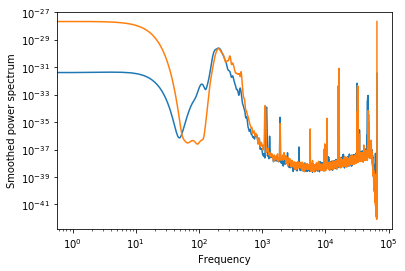

In [24]:
# I took this function from phys641/lecture9
def smooth_data(vec,fwhm):
    n=len(vec)
    x=np.arange(n)
    x[int(n/2):]=x[int(n/2):]-n 
    sig=fwhm/np.sqrt(8*np.log(2))
    y=np.exp(-0.5*x**2/sig**2)
    y=y/np.sum(y)
    
    vecft=np.fft.rfft(vec)
    yft=np.fft.rfft(y)
    vec_smooth=np.fft.irfft(yft*vecft,n)
    return vec_smooth

# list with the smoothed spectra coming from H data
N_H = []

# list with the smoothed spectra coming from H data
N_L = []

# smooth the power spectrum, this is the noise model!
for i in range(len(fname_H)):
    N_H.append(smooth_data(power_spectra_H[i],20))
    N_L.append(smooth_data(power_spectra_L[i],20))
# An example of one of the smooth power spectra
plt.figure()
plt.loglog(N_H[0])
plt.loglog(N_L[0])
plt.ylabel('Smoothed power spectrum')
plt.xlabel('Frequency')


## Part b)

Before doing the match filter procedure, it is necessary to understand what we are doing in practice. By matching the template with the data, we are essentially fitting a model. Recall the best fit parameters of the model will be given by:

\begin{equation}
m = (A^T N^{-1}d)(A^T N^{-1}A)^{-1}
\end{equation}

were $A$ is the model (template), $N$ is the noise, and $d$ is the data. We will assume -incorreclty- that the noise is uncorrelated, so $N$ is a diagonal matrix.

But before fitting we will perform a "pre-whitening" procedure. This means, re-writing the equation with $A$ a new variable, and $N$ the identity. To do this, we will use the following properties: $N^T=N$ and $(AB)^T=B^T A^T$.

\begin{equation}
m = (A^T N^{-1/2}N^{-1/2}d)(A^T N^{-1/2}N^{-1/2}A)^{-1} = \big[(N^{-1/2}A)^T \mathbb{1}(N^{-1/2}d)\big] \big[(N^{-1/2}A)^T \mathbb{1}(N^{-1/2}A)\big]^{-1}
\end{equation}

So that the new model we are fitting is $N^{-1/2}A$ and our modified data is $N^{-1/2}d$.

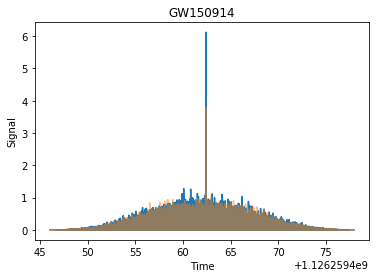

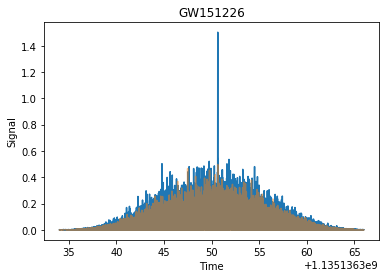

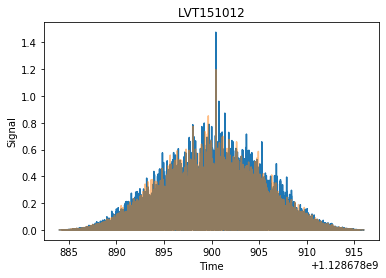

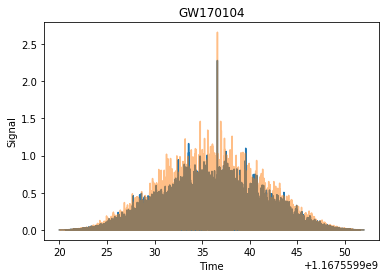

In [26]:
# This function returns whitened data and template, for H and L
# i.e., strain_white_H, strain_white_L, temp_white_H, temp_white_L

def matchfilter(window_strainH,window_strainL,templateH,templateL,N_H,N_L,timeH,timeL,GWname):
    n=len(window_strainH)

    # Define N^{1/2}
    Nmhalf_H=1/np.sqrt(N_H)
    Nmhalf_L=1/np.sqrt(N_L)

    # cut the fake noise at low and high frequencies
    Nmhalf_H[:200]=0
    Nmhalf_H[53000:]=0
    Nmhalf_L[:200]=0
    Nmhalf_L[53000:]=0


    # Take the Fourier Transform (FFT) of the data (with dwindow)
    strainft_H=np.fft.rfft(window_strainH) # recall window_strain_H[i] = strain_H[i]*np.blackman(len(strain_H[i]))
    strainft_L=np.fft.rfft(window_strainL)
    # this is N^{1/2}*d
    strainft_white_H=Nmhalf_H*strainft_H
    strainft_white_L=Nmhalf_L*strainft_L

    # this is the whitened data in the time domain
    strain_white_H=np.fft.irfft(strainft_white_H,n)
    strain_white_L=np.fft.irfft(strainft_white_L,n)


    # Take the Fourier Transform (FFT) of the template (with dwindow)
    temp_ft_H=np.fft.rfft(templateH*np.blackman(len(window_strainH)))
    temp_ft_L=np.fft.rfft(templateL*np.blackman(len(window_strainL)))

    

    # This is N^{1/2}*A
    tempft_white_H=Nmhalf_H*temp_ft_H # frequency domain
    tempft_white_L=Nmhalf_L*temp_ft_L
    
    # this is the whitened template in the time domain
    temp_white_H=np.fft.irfft(tempft_white_H,len(templateH))
    temp_white_L=np.fft.irfft(tempft_white_L,len(templateL))

    # the match filter is the multiplication of the data and the filter in the FOURIER domain
    mf_ft_H=strainft_white_H*np.conj(tempft_white_H)
    mf_ft_L=strainft_white_L*np.conj(tempft_white_L) 
    

    # Calculate the matched filter output in the time domain:
    mf_H=np.fft.irfft(mf_ft_H)
    mf_H = np.fft.fftshift(mf_H)
    mf_H=np.abs(mf_H)
    mf_L=np.fft.irfft(mf_ft_L)
    mf_L = np.fft.fftshift(mf_L)
    mf_L=np.abs(mf_L)
    
    # plots
    plt.figure()
    plt.title(GWname)
    plt.plot(timeH,mf_H)
    plt.plot(timeL,mf_L, alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    return strain_white_H,strain_white_L,temp_white_H,temp_white_L,tempft_white_H,tempft_white_L,mf_H,mf_L

# we want strain_white_H,strain_white_L,th_white_H,th_white_L for each GW so...

strains_white_H = []
strains_white_L = []
templates_white_H = []
templates_white_L = []

# these lists are for part f)

templatesFT_white_H = []
templatesFT_white_L = []

matchfilter_H = []
matchfilter_L = []


for i in range(len(fname_H)):
    strainH,strainL,tempH,tempL,tempFTH,tempFTL,mfH,mfL = matchfilter(window_strain_H[i],window_strain_L[i],t_H[i],t_L[i],
                                                 N_H[i],N_L[i],time_H[i],time_L[i],GWs[i])
    
    strains_white_H.append(strainH)
    strains_white_L.append(strainL)
    templates_white_H.append(tempH)
    templates_white_L.append(tempL)
    templatesFT_white_H.append(tempFTH)
    templatesFT_white_L.append(tempFTL)
    matchfilter_H.append(mfH)
    matchfilter_L.append(mfL)
  

## Part c)

To figure out the noise, we use the square root of the covariance matrix: $<m \, m^T>^{1/2}$, which is given by

\begin{equation}
<m \, m^T> = <(A^T N^{-1}A)^{-1}A^T N^{-1}d \, d^T N^{-1}A \, (A^T N^{-1}A)^{-1}>
\end{equation}

if the contribution of the GW signal is small, we could say that it's almost like if the signal was part of the noise, i.e., $dd^T\approx N$. In that case:

\begin{equation}
<m \, m^T> = <(A^T N^{-1}A)^{-1}A^T N^{-1}A (A^T N^{-1}A)^{-1}> = <(A^T N^{-1}A)^{-1})> 
\end{equation}

but since we did a pre-whitening before, we instead have:

\begin{equation}
<m \, m^T> = <((N^{-1/2}A)^{T} \mathbb{1} (N^{-1/2} A))^{-1}> 
\end{equation}

So finally, the noise is $\sigma_m \approx \sqrt{<m \, m^T>} = (<(N^{-1/2}A)^{T} \mathbb{1} (N^{-1/2} A)>)^{-1/2} $.

The signal to noise is defined as 

\begin{equation}
SNR=\frac{m}{\sigma_m} = \big(N^{-1/2}A)^{T} \mathbb{1} (N^{-1/2} d\big) \big(N^{-1/2}A)^{T} \mathbb{1} (N^{-1/2} A\big)^{1/2} 
\end{equation}

Because we did a multiplication in the fourier domain to match the template to the data, what we have in the code is the following:

\begin{equation}
m = \frac{IFT[FT((N^{-1/2}A)^{T})* FT(N^{-1/2}d)]}{(N^{-1/2}A)^{T}(N^{-1/2}A)} 
\end{equation}

Then, the SNR will be:

\begin{equation}
SNR = m [(N^{-1/2}A)^{T}(N^{-1/2} A)]^{1/2}
\end{equation}




In [29]:
# I'll calculate the noise and SNR in the time domain
# To compute the noise, N^{1/2}*A is needed. This is given by the variable thft_white
# but since I want it in the time domain, I'll use just th_white

noise_eachevent_H,noise_eachevent_L = [],[]
SNR_eachevent_H,SNR_eachevent_L = [],[]
time_at_event_H,time_at_event_L = [],[]


for i in range(len(fname_H)):
    sigma_H = 1.0/np.sqrt(templates_white_H[i]**2)   # this would be ((N^{-1/2}*A)^T*N^{-1/2}*A)^(-1/2)
    sigma_L = 1.0/np.sqrt(templates_white_L[i]**2)
    
    # and the best fit parameter
    m_H = (templates_white_H[i]*strains_white_H[i])/(templates_white_H[i]**2)
    m_L = (templates_white_L[i]*strains_white_L[i])/(templates_white_L[i]**2)
    
    # So the SNR is m/sigma for each event
    #SNR_H = m_H/sigma_H
    #SNR_L = m_L/sigma_L
    SNR_H = (templates_white_H[i]*strains_white_H[i])*np.sqrt(templates_white_H[i]**2)
    SNR_L = (templates_white_L[i]*strains_white_L[i])*np.sqrt(templates_white_L[i]**2)
    # For the event, the SNR is on the maximum value, i.e., where N is lower and S is higher    
    indmax_H = np.argmax(SNR_H)
    timemax_H = time_H[i][indmax_H]
    indmax_L = np.argmax(SNR_L)
    timemax_L = time_L[i][indmax_L]
    # this is the SNR of the matched filter
    SNRmax_H = SNR_H[indmax_H]
    noisemax_H = sigma_H[indmax_H]
    SNRmax_L = SNR_L[indmax_L]
    noisemax_L = sigma_L[indmax_L]
    # saving into lists
    noise_eachevent_H.append(noisemax_H)
    SNR_eachevent_H.append(SNRmax_H)
    time_at_event_H.append(timemax_H)
    noise_eachevent_L.append(noisemax_L)
    SNR_eachevent_L.append(SNRmax_L)
    time_at_event_L.append(timemax_L)

# Testing.
# For the first GW I estimate the event is at time obs time:
print('obs time',46+1.1262594e+9)

# this is the real time according to the highest SNR
print('time at event from match filter (H)',time_at_event_H[0],'SNR at event',SNR_eachevent_H[0])
print('time at event from match filter (L)',time_at_event_L[0],'SNR at event',SNR_eachevent_L[0])
print('')
print('Signal-to-noise for each event in H:',SNR_eachevent_H)
print('Signal-to-noise for each event in L:',SNR_eachevent_L)

obs time 1126259446.0
time at event from match filter (H) 1126259461.9854736 SNR at event 0.9770191768214794
time at event from match filter (L) 1126259461.975952 SNR at event 0.5915831309106514

Signal-to-noise for each event in H: [0.9770191768214794, 0.052607111907760115, 0.15491848597369617, 1.1482766105937947]
Signal-to-noise for each event in L: [0.5915831309106514, 0.027290401707702895, 0.1728621007905407, 0.4364287710765912]


The SNR of both detectors at the same time will be $SNR_{total}= \sqrt{SNR_L^2+SNR_H^2}$

In [30]:
for i in range(len(SNR_eachevent_H)):
    print('For event',GWs[i], 'the total SNR is',np.sqrt(SNR_eachevent_H[i]**2+SNR_eachevent_L[i]**2))

For event GW150914 the total SNR is 1.1421633301130667
For event GW151226 the total SNR is 0.05926444337579987
For event LVT151012 the total SNR is 0.23212290534564087
For event GW170104 the total SNR is 1.2284173747795155


## Part d)


By looking at the scatter in the match filter, it's possible to estimate the SNR by eye.

- For GW150914, H: the noise amplitude is about 1, and the event amplitude is about 6. So, SNR ~ 6. 
- For GW150914, L: the noise amplitude is about 1, and the event amplitude is about 4. So, SNR ~ 4.
- For GW151226, H: the noise amplitude is about 0.5, and the event amplitude is about 1.5. So, SNR ~ 3. 
- For GW151226, L: the noise amplitude is about 0.4, and the event amplitude is about 0.5. So, SNR ~ 1.25.
- For LVT151012, H: the noise amplitude is about 0.9, and the event amplitude is about 1.5. So, SNR ~ 1.6. 
- For LVT151012, L: the noise amplitude is about 0.7, and the event amplitude is about 1.2. So, SNR ~ 1.7.
- For GW170104, H: the noise amplitude is about 1.2, and the event amplitude is about 2.3. So, SNR ~ 1.9. 
- For GW170104, L: the noise amplitude is about 1.5, and the event amplitude is about 2.6. So, SNR ~ 1.7.


Compared to SNR $<1$ (for all events), which is the analytic result from the noise model, the some of the SNRs are 1-2 orders of magnitude different from the observed. Obviously, they disagree. The SNR obtained from the noise model tells us that the noise is stronger than the event signal, which makes sense when looking at the plots strain vs time of part (a). However, since the data was processed in order to detect the GW (windowing, smoothing, whitening, fourier transformig...), this should not be a problem. So, the only explanation that comes to my head, is that the problem comes from how are we calculating $\sigma_m \approx \sqrt{<m \, m^T>}$. Here, we assumed that the noise is uncorrelated, but more importantly, we have assumed that the contribution of the GW signal is small ($dd^T\approx N$). This means that all the SNR I obtained from the theoretical analysis (see derivation from part (c)) will consider that the GW signal is small, and almost the same as the noise.

## Part e)

To find the frequency at which half of the weight comes from above (and below) that frequency, we need to compute the cumulative sum.

To do this, I'll use numpy.cumsum and plot the result as 'steps'. Because I'm looking for a frequency, I need the whitened template in the fourier space! These are the last 2 outputs of the function $matchfilter$.

In GW150914 the frequency where half weight comes from above (and below) is:  131.5 for H, and: 130.53125 for L
In GW151226 the frequency where half weight comes from above (and below) is:  141.34375 for H, and: 170.71875 for L
In LVT151012 the frequency where half weight comes from above (and below) is:  111.71875 for H, and: 148.15625 for L
In GW170104 the frequency where half weight comes from above (and below) is:  126.53125 for H, and: 113.9375 for L


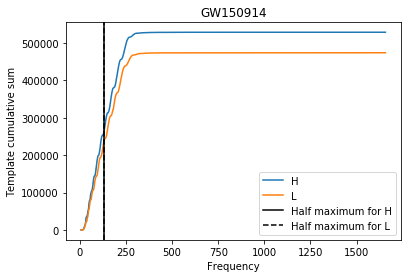

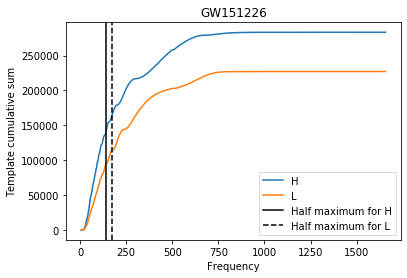

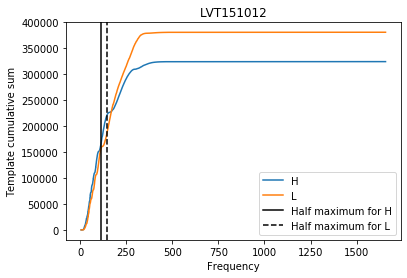

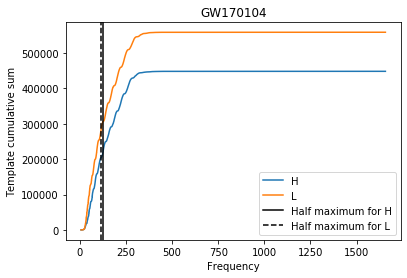

In [31]:
# CUMULATIVE SUM TRIAL removing all the negative amplitudes

def remove_negs(lista,freq):
    new_lista = []
    new_freq = []
    freq = freq.tolist()
    lista = lista.tolist()
    for i in range(len(lista)):
        if lista[i]>0:
            new_lista.append(lista[i])
            new_freq.append(freq[i])
    return new_lista,new_freq

def findfrequency(lista,freq):
    # find the maximum
    max_value = max(lista)
    # find the value of half the maximum
    half_value = max_value/2.0
    # find the nearest value to half_value in the list
    n = [abs(i-half_value) for i in lista]
    idx = n.index(min(n))
    return freq[idx]

for i in range(len(fname_H)):
    # take the template for H and L in the fourier space
    tempH = np.real(templatesFT_white_H[i])
    tempL = np.real(templatesFT_white_L[i])
    # remove negative amplitudes
    temp_new_H,freq_H = remove_negs(tempH,frequency_H[i])
    temp_new_L,freq_L = remove_negs(tempL,frequency_L[i])
    # compute cumulative sum
    temp_sum_H = np.cumsum(temp_new_H)
    temp_sum_L = np.cumsum(temp_new_L)
    # plot the results for each detector
    plt.figure()
    plt.step(freq_H,temp_sum_H,label='H')
    plt.step(freq_L,temp_sum_L,label='L')
    plt.title(GWs[i])
    plt.legend(loc='best')
    plt.xlabel('Frequency')
    plt.ylabel('Template cumulative sum')
    # compute the frequency value
    half_freq_H = findfrequency(temp_sum_H,freq_H)
    half_freq_L = findfrequency(temp_sum_L,freq_L)
    plt.axvline(x=half_freq_H,color='black',label='Half maximum for H')
    plt.axvline(x=half_freq_L,color='black',linestyle='--',label='Half maximum for L')
    plt.legend(loc='best')
    print('In',GWs[i],'the frequency where half weight comes from above (and below) is: ',half_freq_H,
          'for H, and:',half_freq_L,'for L')


In GW150914 the frequency where half weight comes from above (and below) is:  6.375 e-27 for H, and: 0.53125 e-27 for L
In GW151226 the frequency where half weight comes from above (and below) is:  6.53125 e-27 for H, and: 8.0625 e-27 for L
In LVT151012 the frequency where half weight comes from above (and below) is:  6.4375 e-27 for H, and: 6.53125 e-27 for L
In GW170104 the frequency where half weight comes from above (and below) is:  7.90625 e-27 for H, and: 0.53125 e-27 for L


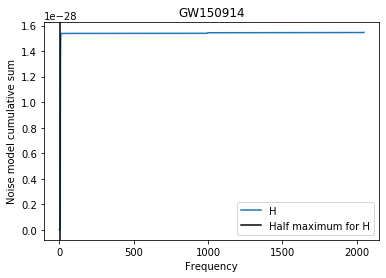

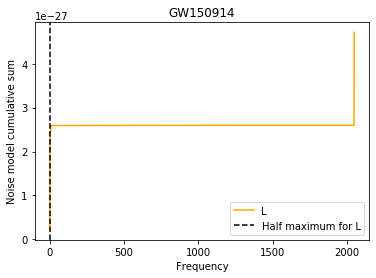

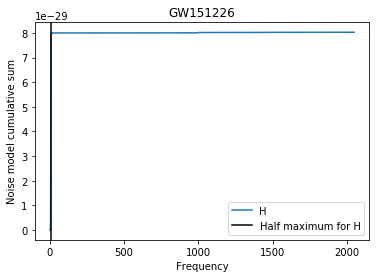

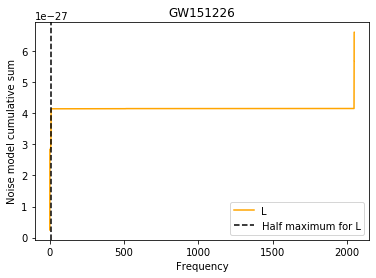

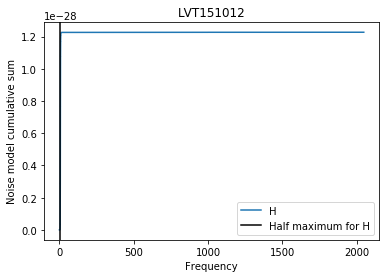

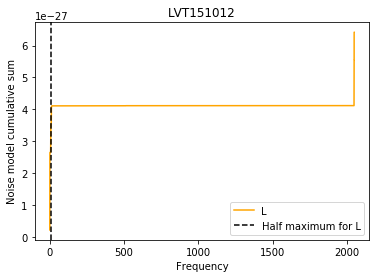

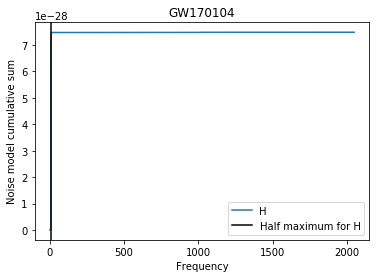

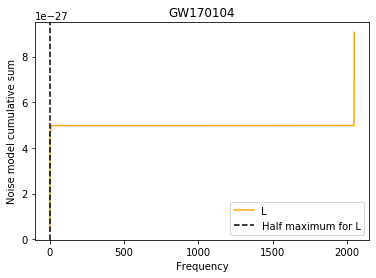

In [32]:
for i in range(len(fname_H)):
    # Now do the same with the noise model
    # compute cumulative sum of the noise model in the Fourier space
    noise_sum_H = np.cumsum(N_H[i])
    noise_sum_L = np.cumsum(N_L[i])
    # compute the frequency value
    noisehalf_freq_H = findfrequency(noise_sum_H,frequency_H[i])
    noisehalf_freq_L = findfrequency(noise_sum_L,frequency_L[i])
    # plot the results for each detector
    plt.figure()
    plt.step(frequency_H[i],noise_sum_H,label='H')
    plt.axvline(x=noisehalf_freq_H,color='black',label='Half maximum for H')
    plt.title(GWs[i])
    plt.legend(loc='best')
    plt.xlabel('Frequency')
    plt.ylabel('Noise model cumulative sum')
    plt.figure()
    plt.step(frequency_H[i],noise_sum_L,label='L',color='orange')
    plt.axvline(x=noisehalf_freq_L,color='black',linestyle='--',label='Half maximum for L')
    plt.title(GWs[i])
    plt.legend(loc='best')
    plt.xlabel('Frequency')
    plt.ylabel('Noise model cumulative sum')

    print('In',GWs[i],'the frequency where half weight comes from above (and below) is: ',noisehalf_freq_H,
          'e-27 for H, and:',noisehalf_freq_L,'e-27 for L')

## Part f)

To localize the time of arrival for the detectors, first it is necessary to determine the time at which the event ocurred. Because we are looking for the horizontal shift of the matched filter, let's plot how this shift looks like.

Look at the Hanford data:

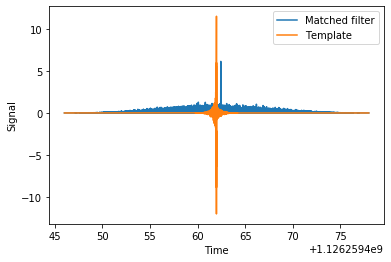

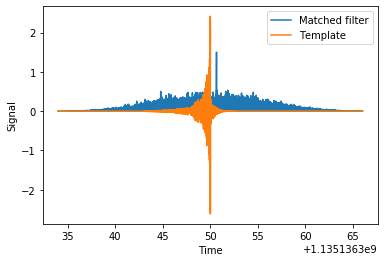

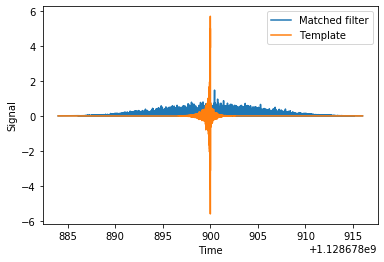

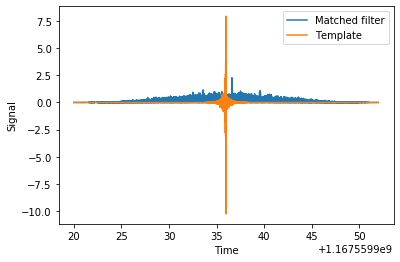

In [33]:
for i in range(len(fname_H)):
    plt.figure()
    plt.plot(time_H[i],matchfilter_H[i], label='Matched filter')
    plt.plot(time_H[i],templates_white_H[i],label='Template')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    

And now to the Livingston data

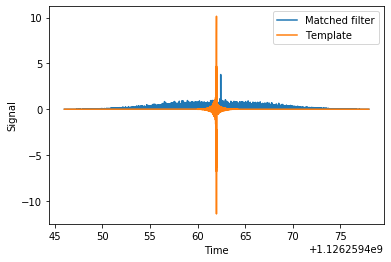

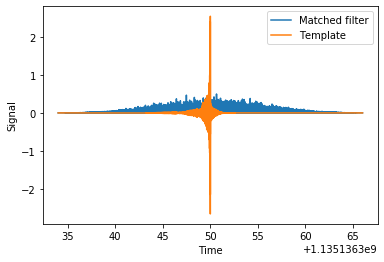

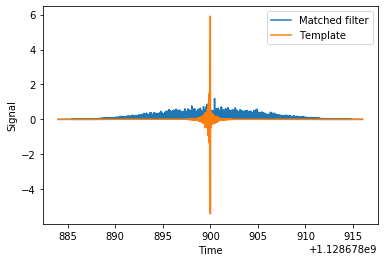

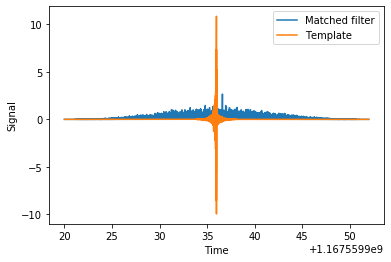

In [34]:
for i in range(len(fname_H)):
    plt.figure()
    plt.plot(time_L[i],matchfilter_L[i], label='Matched filter')
    plt.plot(time_L[i],templates_white_L[i],label='Template')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Signal')

Clearly, there is a shift between the template (the model) and the data (where the event actually happens). The time difference between the two peaks (one from the template and one for the matched filter), will be the time of arrival. The uncertainty in the time will also be given by this difference. In the following lines, I compute the time of arrival for each event and each detector.

In [35]:
# For H detector
for i in range(len(fname_H)):
    # Calculate the index were the peak occurs in the template
    index_temp = (templates_white_H[i].tolist()).index(max(templates_white_H[i]))
    # Calculate the index were the peak occurs in the matched filter
    index_mf = (matchfilter_H[i].tolist()).index(max(matchfilter_H[i]))
    print(GWs[i])
    print('Time at event according to template:',time_H[i][index_temp])
    print('Time at event according to matched filter:',time_H[i][index_mf])

GW150914
Time at event according to template: 1126259461.9857178
Time at event according to matched filter: 1126259462.440555
GW151226
Time at event according to template: 1135136349.98938
Time at event according to matched filter: 1135136350.6478322
LVT151012
Time at event according to template: 1128678899.9962158
Time at event according to matched filter: 1128678900.4415317
GW170104
Time at event according to template: 1167559935.9815671
Time at event according to matched filter: 1167559936.6080368


In [36]:
# For L detector
for i in range(len(fname_H)):
    # Calculate the index were the peak occurs in the template
    index_temp = (templates_white_L[i].tolist()).index(max(templates_white_L[i]))
    # Calculate the index were the peak occurs in the matched filter
    index_mf = (matchfilter_L[i].tolist()).index(max(matchfilter_L[i]))
    print(GWs[i])
    print('Time at event according to template:',time_L[i][index_temp])
    print('Time at event according to matched filter:',time_L[i][index_mf])

GW150914
Time at event according to template: 1126259461.9869385
Time at event according to matched filter: 1126259462.431766
GW151226
Time at event according to template: 1135136349.9986572
Time at event according to matched filter: 1135136350.6478322
LVT151012
Time at event according to template: 1128678899.9976807
Time at event according to matched filter: 1128678900.4434848
GW170104
Time at event according to template: 1167559935.9832761
Time at event according to matched filter: 1167559936.6129198


To calculate the real time difference, these gps values must be converted into utc. To do this, I used the following website: https://www.gw-openscience.org/gps/.

GW150914
- Template time of arrival H: 1126259461.9857178 or 2015-09-14T09:50:44
- MF time of arrival H: 1126259462.440555 or 2015-09-14T09:50:45
- Template time of arrival L: 1126259461.9869385 or 2015-09-14T09:50:44
- MF time of arrival L: 1126259462.431766 or 2015-09-14T09:50:45

GW151226
- Template time of arrival H: 1135136349.98938 or 2015-12-26T03:38:52
- MF time of arrival H: 1135136350.6478322 or 2015-12-26T03:38:53
- Template time of arrival L: 1135136349.9986572 or 2015-12-26T03:38:52
- MF time of arrival L: 1135136350.6478322 or 2015-12-26T03:38:53

LVT151012
- Template time of arrival H: 1128678899.9962158 or 2015-10-12T09:54:42
- MF time of arrival H: 1128678900.4415317 or 2015-10-12T09:54:43
- Template time of arrival L: 1128678899.9976807 or 2015-10-12T09:54:42
- MF time of arrival L: 1128678900.4434848 or 2015-10-12T09:54:43

GW170104
- Template time of arrival H: 1167559935.9815671 or 2017-01-04T10:11:57
- MF time of arrival H: 1167559936.6080368 or 2017-01-04T10:11:58
- Template time of arrival L: 1167559935.9832761 or 2017-01-04T10:11:57
- MF time of arrival L: 1167559936.6129198 or 2017-01-04T10:11:58

So in all events, the difference in time is 1 second.

The uncertainties in the time are known now, so the uncertainty in the position will be $v \,\delta t = \delta x$, where $v$ is the velocity of the gravitational wave (speed of light). This gives an uncertainty in the position of $3\times10^8$ m, which is a terrible result!!!!!!!!!!!!
This means that the uncertainty in the time should be really small, in order to get a small uncertainty in the position. Considering that the detectors are ~3000 km apart, a wave travelling at the speed of light should take ~$10^{-2}$ seconds to go from one detector to the other. Our model needs to be improved to the point where it is capable of reproducing an uncertainity in time of order $10^{-2}$.